# Logging of the project

In this notebook you will find all the steps it took us to accurately predict the temperature of nuclear waste canister. 

### **Imports** 

In [1]:
random_state = 42
## data handling 
import numpy as np
import pandas as pd
import random

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Sklearn 
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=8, shuffle=True, random_state=random_state) # can specify a random_state if needed (for reproduceability)

## comfort things
from typing import Tuple
from sys import exit
import functions as func

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Progress bar
from tqdm.auto import tqdm

# metrics
import metrics

## --- GPU DOESNT WORK WITH SMALL BACTH SIZE ---

# ## Use CUDA cores if available: 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Output device information
# if torch.cuda.is_available():
#     print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
# else:
#     print("CUDA is not available. Using CPU.")

device = torch.device("cpu")

### **Loading of the datasets** 

In [2]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

Let's get the sensor IDs in a list before some of them are deleted, and also the time stamps:

In [3]:
sensor_IDs = pressure_train.columns[1:]

## Chech that none is missing: 
for i, sens in enumerate(sensor_IDs):
    assert 'N_'+str(i+1) == sens

## We will also need the mean and std of the time to add it as a feature in the model later
time: list = pressure_train['M.Time[d]'].to_list()
time_mean = np.mean(time)
time_std = np.std(time)

time_pred: list = pressure_pred['M.Time[d]'].to_list()
time_pred_mean = np.mean(time)
time_pred_std = np.std(time)

### **Imputing the datasets**


In [4]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors=2).set_output(transform="pandas")

## The imputer actually deletes columns with no data so we need to identify the columns with no data first
## We need to know those sensors to remove the associated data in the other dataframes. 
## It is needed because the values are mainly linked by having the same index in all dataframes.

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

test_faulty_sensors = []
for sensor in pressure_pred.columns[1:]:
    if pressure_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
    elif humidity_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
print(f'Faulty sensors in prediction datasets: {test_faulty_sensors}')
# Actually no sensors in the test dataset has no data

## We need to impute the missing values with a KNN imputer so it can be plotted a first time: 
## Which requires renaming the columns: 

## Not keeping useless columns:
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
# The sensor ID will be usefull to group the data into a numpy array

# changing the column names for faster typing later
new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)




Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']
Faulty sensors in prediction datasets: []


#### **Coordinates**

In [5]:
display(coordinates_train.sample(5))
coordinates_train.info()
coordinates_train["Material"].unique()

,id,Material,x,y,z,r
872,N_873,OPA,-3.130858,29.361992,0.767665,3.223598
233,N_234,OPA,-6.340404,22.269387,14.316268,15.657466
203,N_204,OPA,12.693046,6.105267,-8.705361,15.391450
42,N_43,OPA,18.344543,8.312649,-0.744563,18.359646
142,N_143,OPA,-5.949670,10.649680,13.853073,15.076678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        900 non-null    object 
 1   Material  900 non-null    object 
 2   x         900 non-null    float64
 3   y         900 non-null    float64
 4   z         900 non-null    float64
 5   r         900 non-null    float64
dtypes: float64(4), object(2)
memory usage: 42.3+ KB


array(['OPA', 'SHCR', 'GBM', 'EDZ', 'VOID', 'CAN', 'BBLOCK'], dtype=object)

We can see there are no missing data and apparently no false measures (outliers) on the position and the material, but some columns are useless like the numbering of rows and the index. Because the rows are in an ascending order and as long as the indices match between the files, the number doesn't matter. We are also renaming the columns to make it easier later.  

We will also one-hot encode the Material column to feed it later in the model, as they are caterogical features. 

In [6]:

## One-hot encoding:
## cf intro to pandas notebook from the weekly exercises
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 
display(coordinates_pred.head(5))
display(coordinates_train.head(5))

## the coordinates_pred is missing the columns "Material_BBLOCK" and "Material_VOID" that we have to add 
# Make a copy to be safe
df = coordinates_pred.copy()
# Create the new column with default value (e.g., 0 or NaN)
df["Material_BBLOCK"] = False  # or use np.nan if needed
df["Material_VOID"] = False
# Get column list and rearrange
cols = df.columns.tolist()
# Find index of "r"
r_index = cols.index("r")
# Insert "Material_BBLOCK" right after "r"
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]


display(coordinates_pred.head(5))


,id,x,y,z,r,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_901,0.295918,30.011150,1.776254,1.800735,False,False,False,True,False
1,N_902,2.274456,25.204297,2.957595,3.731021,False,False,False,True,False
2,N_903,-0.586165,27.600980,-1.869516,1.959255,False,False,False,True,False
3,N_904,-1.680052,40.394076,-0.297226,1.706142,False,True,False,False,False
4,N_905,2.840656,38.093588,2.125899,3.548066,False,False,False,True,False


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False,False
1,N_2,-8.970832,28.229841,-0.134437,8.971839,False,False,False,False,True,False,False
2,N_3,-14.289501,6.685726,-10.399048,17.672862,False,False,False,False,True,False,False
3,N_4,6.114855,2.685645,-3.189981,6.896914,False,False,False,False,True,False,False
4,N_5,4.048845,48.708590,11.260503,11.966289,False,False,False,False,True,False,False


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_901,0.295918,30.011150,1.776254,1.800735,False,False,False,False,True,False,False
1,N_902,2.274456,25.204297,2.957595,3.731021,False,False,False,False,True,False,False
2,N_903,-0.586165,27.600980,-1.869516,1.959255,False,False,False,False,True,False,False
3,N_904,-1.680052,40.394076,-0.297226,1.706142,False,False,True,False,False,False,False
4,N_905,2.840656,38.093588,2.125899,3.548066,False,False,False,False,True,False,False


#### **Pressure**

In [7]:
display(pressure_train.head(5))
display(pressure_pred.head(5))
pressure_train.isnull().sum().sum() # See how many missing values there are

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,281.143955,1462.382827,1656.041967,1322.584393,1473.656845,1480.325846,1650.794639,1511.445756,1397.850463,...,-57423.47996,202.296319,395.883971,651.026983,-405.358355,-60428.68990,-768.389510,336.655683,-63100.53626,831.154054
1,1556,279.968800,1461.806069,1656.007440,1322.251688,1473.611215,1480.290558,1650.692513,1511.327468,1397.594172,...,-57398.67576,201.782481,395.553760,649.949956,-405.782281,-60422.76359,-769.736168,335.531920,-63004.35183,830.963631
2,1558,278.797310,1461.224531,1655.972023,1321.919350,1473.565180,1480.255784,1650.589484,1511.207764,1397.338620,...,-57373.82834,201.470400,395.458253,648.902434,-405.531701,-60416.87545,-771.054710,334.539419,-62924.41589,830.870655
3,1560,277.631157,1460.639147,1655.935750,1321.587287,1473.518663,1480.221507,1650.485576,1511.086587,1397.083769,...,-57348.80938,201.459983,395.687942,647.909216,-404.343841,-60411.01323,-772.329622,333.773806,-62855.88550,830.915078
4,1563,275.898544,1459.753528,1655.879443,1321.089332,1473.447601,1480.170896,1650.327726,1510.901301,1396.702138,...,-57310.61967,202.456185,397.004063,646.629125,-400.066605,-60402.23717,-774.086664,333.414898,-62770.54127,831.441631


,M.Time[d],N_901,N_902,N_903,N_904,N_905,N_906,N_907,N_908,N_910,...,N_1037,N_1038,N_1039,N_1040,N_1041,N_1042,N_1043,N_1044,N_1045,N_1046
0,1554,-1333.500175,386.194902,-1049.282902,-20803.85823,474.872227,570.018394,529.515025,555.018892,775.501527,...,-126.640724,-1070.136961,225.906111,469.774141,391.178122,-479.584900,556.931735,373.737677,89.428750,265.583739
1,1556,-1334.513483,384.758889,-1050.185275,-20797.24217,473.676124,568.711926,527.915109,554.090897,774.679991,...,-127.411240,-1071.242824,224.310625,468.193225,390.127110,-480.957720,556.105085,372.578154,88.057178,265.342575
2,1558,-1335.179754,383.334619,-1050.517570,-20790.64746,472.525435,567.430195,526.317494,553.195198,773.886428,...,-127.443883,-1072.224533,222.717540,466.614842,389.127943,-482.236339,555.287433,371.484692,86.818389,265.397340
3,1560,-1335.433509,381.949597,-1050.130043,-20784.05414,471.469214,566.211407,524.745813,552.354596,773.134262,...,-126.547182,-1073.032056,221.133268,465.078561,388.209527,-483.348682,554.488506,370.532170,85.829156,265.873123
4,1563,-1334.889994,380.082466,-1047.806350,-20774.09140,470.278537,564.672055,522.536752,551.326356,772.148001,...,-123.028541,-1073.715109,218.802296,463.033468,387.135795,-484.404887,553.372469,369.668011,85.266828,267.852146


0

No missing value here.

First we will handle outliers

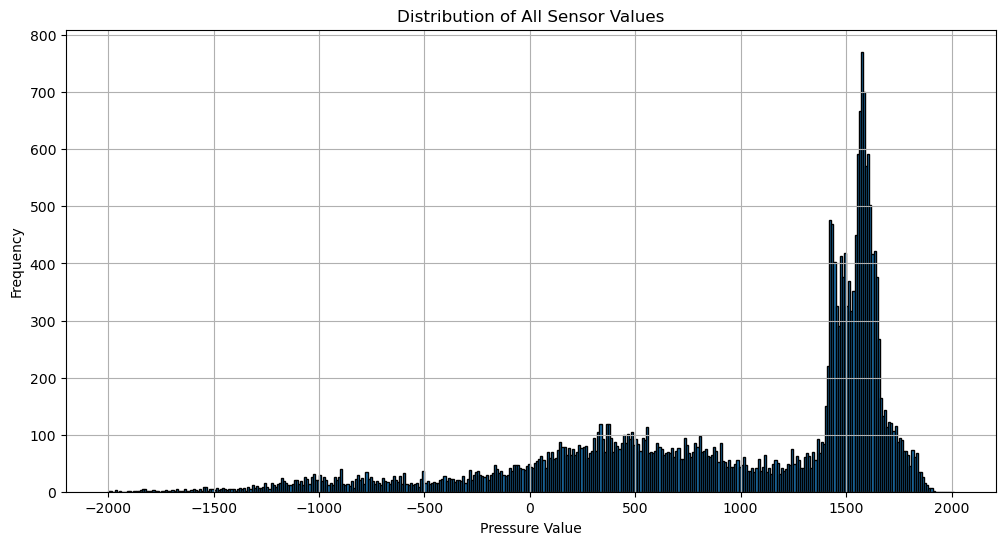

-4595.805803237333
17488.72888179162


In [8]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(-2000, all_values.max() + 100, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))


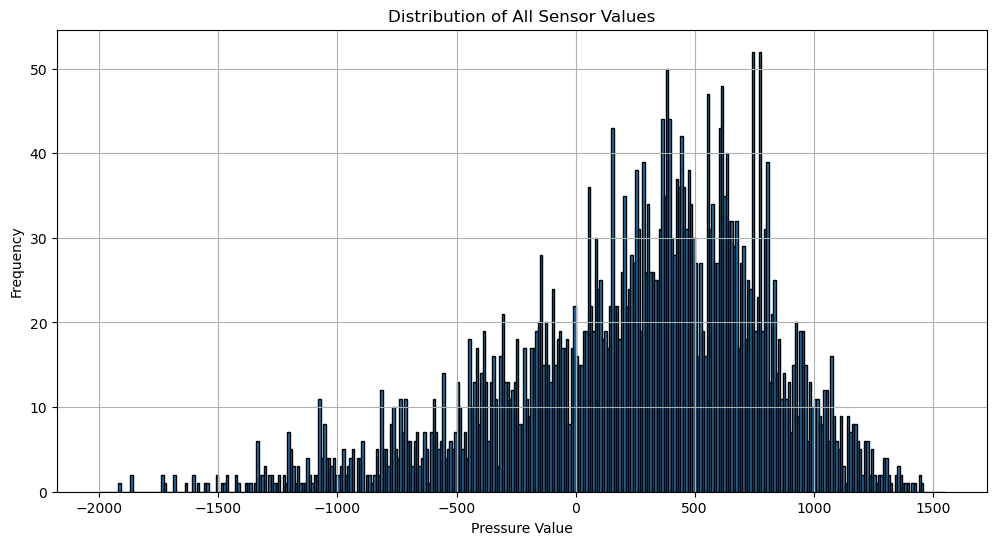

-6714.818665868153
18732.12920533961


In [9]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(-2000, all_values.max() + 100, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))

We clearly have false measures in our data as there is no trend in those large negative values and a very small frequency. To fix this, we will apply a low filter at -1'500. Once we delete this data, we'll try not to delete the whole column/row as it would remove quite a lot of data. So we prefer to impute the missing data, we could use constant or mean imputation but we'll use KNN imputation to replace them, with 2 neighbors as it will more likely preserve the time continuation.  
<font color="red"> should we remove outliers from the test data ? It seems not very clever to try predicting false values...

0 columns in pressure_train are filled with NaN
107 columns in pressure_train are filled with NaN
22 columns in pressure_pred are filled with NaN
0 cells in pressure_train are filled with NaN
0 cells in pressure_pred are filled with NaN


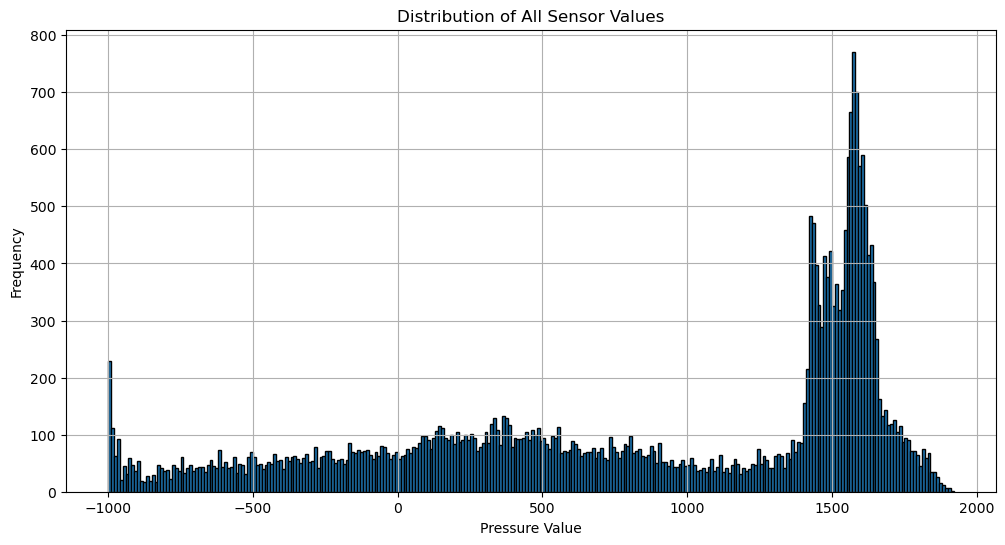

Mean: 845.6146916287337
SD: 812.530808960925


In [10]:
## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')

## clearing values below -1'500:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -1000, np.nan) 
# pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] >= 1500, np.nan) 
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= -1500, np.nan)
# pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] >= 1500, np.nan) 

## Dropping values too high as they dont reflect what we will amke our prediction on
# # Step 1: Define range and compute ratio of values in range per sensor
# lower, upper = 800, 2000
# in_range_ratio = ((pressure_train >= lower) & (pressure_train <= upper)).mean()

# # Step 2: Sort sensors by in-range ratio (higher means more "boring")
# in_range_sorted = in_range_ratio.sort_values(ascending=False)

# # Step 3: Select top 70% of sensors to drop
# n_drop = int(len(in_range_sorted) * 0.50)
# sensors_to_drop = in_range_sorted.head(n_drop).index

# # Step 4: Drop them
# pressure_train = pressure_train.drop(columns=sensors_to_drop)
# humidity_train = humidity_train.drop(columns=sensors_to_drop)
# temperature_train = temperature_train.drop(columns=sensors_to_drop)
# coordinates_train = coordinates_train.drop(coordinates_train[coordinates_train["id"].isin(sensors_to_drop)].index).copy() 
# display(temperature_train.shape)

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = pressure_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')

## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)

## Imputing missing values (if there are some):
pressure_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
pressure_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().sum().sum()
print(f'{count} cells in pressure_train are filled with NaN')
count = pressure_pred.isnull().sum().sum()
print(f'{count} cells in pressure_pred are filled with NaN')

## New shapes (should be the same)
# print("pressure_train shape:"+str(pressure_train.shape))
# print("pressure_pred shape:"+str(pressure_pred.shape))

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## New distribution parameters:
print(f'Mean: {np.mean(all_values)}')
print(f'SD: {np.std(all_values)}')



#### **Humidity**

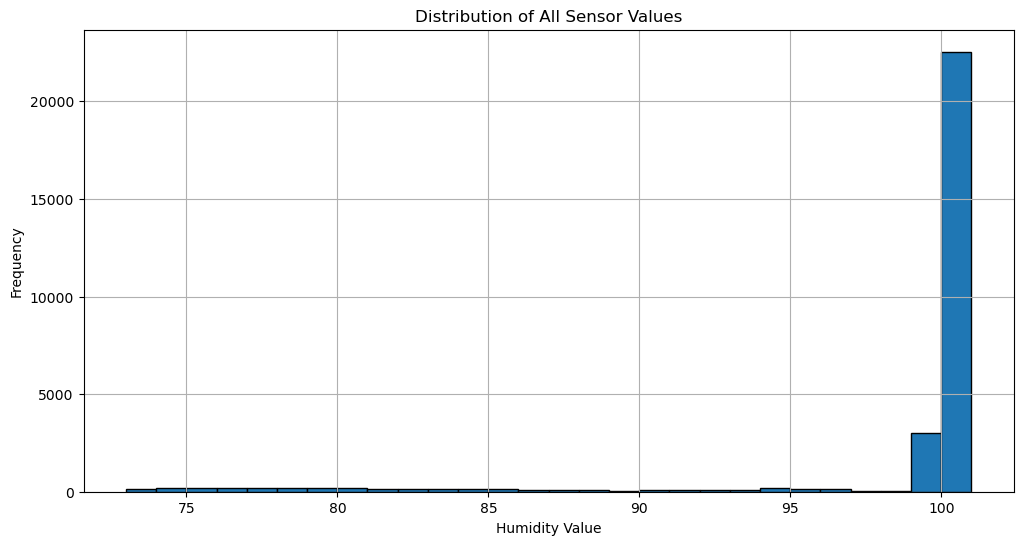

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,100.0,100,100,100,100,100,100,100,100,...,78.853196,100.0,100,100,99.832469,77.872682,99.682618,100.0,77.465508,100
1,1556,100.0,100,100,100,100,100,100,100,100,...,78.861729,100.0,100,100,99.832297,77.874432,99.682059,100.0,78.123191,100
2,1558,100.0,100,100,100,100,100,100,100,100,...,78.871339,100.0,100,100,99.832412,77.876201,99.681512,100.0,78.631360,100
3,1560,100.0,100,100,100,100,100,100,100,100,...,78.882563,100.0,100,100,99.832926,77.878014,99.680985,100.0,79.041955,100
4,1563,100.0,100,100,100,100,100,100,100,100,...,78.904156,100.0,100,100,99.834759,77.880930,99.680263,100.0,79.521958,100


In [11]:
if humidity_train.isna().all().any():
    ## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
    humidity_train = func.fill_NaN_columns(
        K = 5,
        df = humidity_train,
        imputer = imputer,
        coords = coordinates_train
    )

if humidity_pred.isna().all().any():
    humidity_pred = func.fill_NaN_columns(
        K = 5,
        df = humidity_pred,
        imputer = imputer,
        coords = coordinates_pred
    )


## Imputing the missing data
if humidity_train.isna().sum().sum() != 0: 
    humidity_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

if humidity_pred.isna().sum().sum() != 0: 
    humidity_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
    

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

display(humidity_train.head(5))

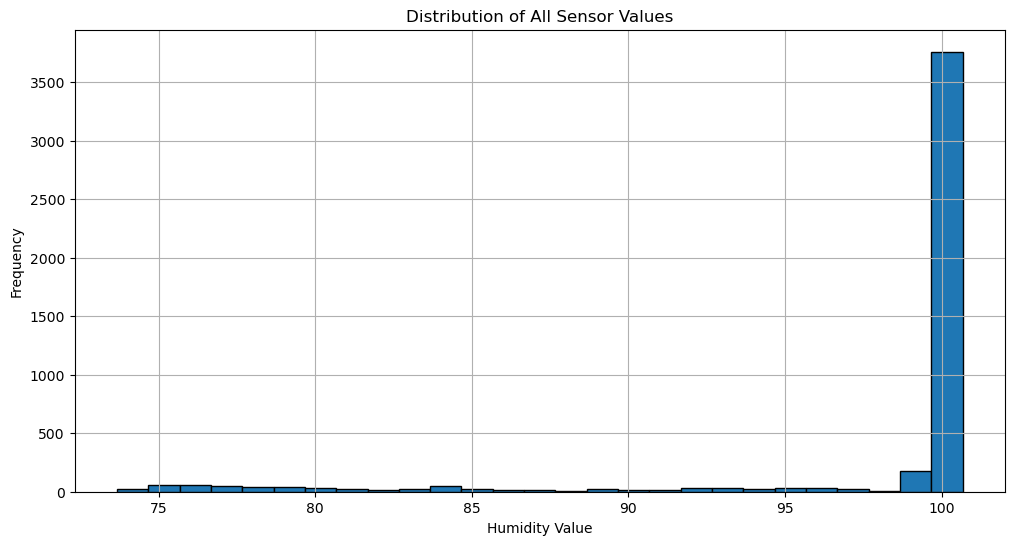

In [12]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


There are some values that appear rarely but they are very realistic so we decided not to clip them.

#### **Temperature**

In [13]:
display(temperature_train.head(5))
print(temperature_train.shape)

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,17.623059,17.154220,17.641578,17.455701,NaN,16.604935,17.662407,16.503001,16.943823,...,17.503931,17.225297,17.498277,17.268529,17.573474,17.412215,17.526257,17.364940,24.026562,17.538194
1,1556,17.620860,17.154263,17.641672,17.455850,16.415312,16.605042,17.662519,16.503121,16.943985,...,17.510776,17.223290,17.498581,17.267488,17.578925,17.409841,17.522860,17.363663,33.729552,17.537460
2,1558,17.618608,17.154303,17.641766,17.455998,16.415377,16.605148,17.662632,16.503240,16.944146,...,17.534085,17.223733,17.501874,2872.837827,17.599256,17.407913,17.520157,17.363850,41.602481,17.537433
3,1560,17.616334,2717.706176,17.641859,17.456146,16.415440,16.605254,17.662744,16.503357,16.944307,...,17.581610,17.228355,17.509670,17.266326,17.640317,17.406770,17.518750,17.366504,48.218980,17.538652
4,1563,17.612991,17.154388,17.642000,17.456367,16.415531,16.605414,17.662912,16.503530,16.944544,...,17.723547,17.249726,17.535358,17.267759,17.757592,17.408069,17.521699,17.379102,56.258743,17.545154


(32, 901)


Here we notice sudden spikes in the temperature going from about 20 to 2'000+ (the mineral would most likely melt at that temperature) and going back down to 20 a few days later. We can consider those value as measurement errors. We can replace those outliers by the mean of the 2 nearest neighbors if they are above a threshold of 60 (we can see it should work well by looking at the graph below), this is called value cliping.

0


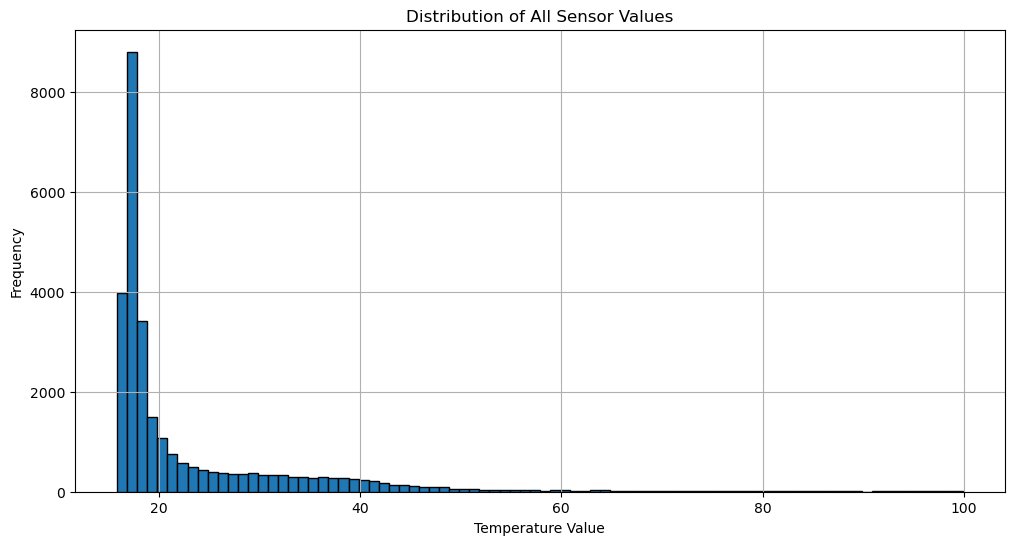

temperature_train shape: (32, 901)
empty columns: 0
temperature_train shape: (32, 901)


In [14]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
temperature_train = func.fill_NaN_columns(
    K = 5,
    df = temperature_train,
    imputer = imputer,
    coords = coordinates_train
)

## We impute the missing data with the 2 nearest neighbors to view the distribution
temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
print(temperature_train.isnull().sum().sum()) # check that it worked

# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), 100, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Applying the filter:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 100, np.nan) ## set filter to 100 to see

## Initial shape: 
print(f'temperature_train shape: {temperature_train.shape}')
print(f'empty columns: {temperature_train.isnull().all().sum()}')

## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

## New shape: 
print(f'temperature_train shape: {temperature_train.shape}')

### **Data augmentation** 

In [15]:
new_times = np.array([1630, 1650, 1680, 1710, 1750, 1800, 1860, 1940, 2010, 2050, 2070, 2150, 2280, 2320, 2470, 2550, 2700, 2800, 2950, 3100, 3300, 3400, 3500, 3800, 4000, 5000, 5200, 5800, 6100, 6700, 6800])
# new_times = np.array([1630, 1640,  1650, 1660, 1680, 1690, 1710, 1720, 1750, 1770, 1800, 1830, 1860, 1900, 1940, 1980, 2010, 2040, 2050, 2060, 2070, 2100, 2150, 2200, 2280, 2300,  2320, 2400, 2470, 2500, 2550, 2600, 2700, 2750, 2800, 2900, 2950, 3000, 3100, 3200, 3300, 3350, 3400, 3450, 3500, 3600, 3800, 3900, 4000, 4500, 5000, 5200, 5800, 6100, 6700, 6800])
time = np.union1d(time, new_times)

## Add new rows:  
pressure_train = pressure_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
humidity_train = humidity_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
temperature_train = temperature_train.set_index('M.Time[d]').reindex(time).interpolate(method='linear').reset_index()
## As the data has been cleared from outliers we can use the pandas interpolation without fearing new outliers (hopefully)

### **Feature engineering**

#### **Data normalization**

Data normalization is essential for a faster convergence of the descent methods and an appropriate penalization of the weights. We will use a z-score scaling technique as a min-max scaling would be scalled up by the few outliers left and concentrate the values too much. We'll then make sure the data is not too heavy-tailed for the scaling to work best.

In [16]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()

humidity_mean = humidity_train.iloc[:,1:].mean(axis=None) 
humidity_std = humidity_train.iloc[:,1:].values.std()

temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()

coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')

# print(f'Mean humidity: {humidity_mean}')
# print(f'SD of humidity: {humidity_std}')

# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_pred.iloc[:,1:] -= pressure_mean
pressure_pred.iloc[:,1:] /= pressure_std

humidity_train.iloc[:,1:] -= humidity_mean
humidity_train.iloc[:,1:] /= humidity_std
humidity_pred.iloc[:,1:] -= humidity_mean
humidity_pred.iloc[:,1:] /= humidity_std

temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std

coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std
coordinates_pred[["x","y","z","r"]] -= coordinates_mean
coordinates_pred[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)

assert np.isclose(humidity_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(humidity_train.iloc[:,1:].values.std(), 1)

assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)

assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



Let's visualize our data before making it into numpy arrays :

In [17]:
display(pressure_train.head(5))
display(humidity_train.head(5))
display(coordinates_train.head(5))
display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,-0.700338,0.738507,0.974400,0.568221,0.752240,0.760363,0.968008,0.798270,0.659902,...,-1.357135,-0.796381,-0.560575,-0.249790,-1.536554,-0.893699,-1.978756,-0.632720,-1.880142,-0.030381
1,1556,-0.701770,0.737805,0.974358,0.567816,0.752185,0.760321,0.967884,0.798126,0.659590,...,-1.358488,-0.797007,-0.560978,-0.251102,-1.537071,-0.894558,-1.980396,-0.634089,-1.880859,-0.030613
2,1558,-0.703197,0.737097,0.974315,0.567411,0.752128,0.760278,0.967759,0.797980,0.659278,...,-1.359680,-0.797387,-0.561094,-0.252378,-1.536765,-0.895181,-1.982002,-0.635298,-1.881480,-0.030726
3,1560,-0.704617,0.736383,0.974271,0.567007,0.752072,0.760236,0.967632,0.797833,0.658968,...,-1.360619,-0.797400,-0.560814,-0.253588,-1.535318,-0.895504,-1.983555,-0.636231,-1.881941,-0.030672
4,1563,-0.706728,0.735305,0.974202,0.566400,0.751985,0.760175,0.967440,0.797607,0.658503,...,-1.361175,-0.796186,-0.559211,-0.255147,-1.530108,-0.895210,-1.985695,-0.636668,-1.882110,-0.030031


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,...,-3.544744,0.325068,0.325068,0.325068,0.294410,-3.724176,0.266987,0.325068,-3.798687,0.325068
1,1556,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,...,-3.543182,0.325068,0.325068,0.325068,0.294378,-3.723855,0.266885,0.325068,-3.678333,0.325068
2,1558,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,...,-3.541424,0.325068,0.325068,0.325068,0.294399,-3.723532,0.266785,0.325068,-3.585340,0.325068
3,1560,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,...,-3.539370,0.325068,0.325068,0.325068,0.294494,-3.723200,0.266689,0.325068,-3.510202,0.325068
4,1563,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,0.325068,...,-3.535418,0.325068,0.325068,0.325068,0.294829,-3.722666,0.266557,0.325068,-3.422362,0.325068


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.016937,-1.027975,-0.380302,-0.860992,False,False,False,False,True,False,False
1,N_2,-1.210408,0.141186,-0.016204,0.084301,False,False,False,False,True,False,False
2,N_3,-1.921589,-1.685009,-1.379661,1.435142,False,False,False,False,True,False,False
3,N_4,0.806761,-2.024077,-0.422075,-0.237832,False,False,False,False,True,False,False
4,N_5,0.530507,1.877074,1.497395,0.549192,False,False,False,False,True,False,False


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,-0.568691,-0.599556,-0.567472,-0.579709,-0.648199,-0.635716,-0.566101,-0.642426,-0.613406,...,-0.576534,-0.594876,-0.576906,-0.592030,-0.571956,-0.582571,-0.575064,-0.585684,-0.147141,-0.574278
1,1556,-0.568836,-0.599553,-0.567466,-0.579699,-0.648199,-0.635709,-0.566094,-0.642418,-0.613396,...,-0.576083,-0.595009,-0.576886,-0.592099,-0.571597,-0.582728,-0.575287,-0.585768,0.491618,-0.574326
2,1558,-0.568984,-0.599550,-0.567460,-0.579689,-0.648194,-0.635702,-0.566086,-0.642410,-0.613385,...,-0.574549,-0.594979,-0.576669,-0.592137,-0.570258,-0.582855,-0.575465,-0.585755,1.009902,-0.574328
3,1560,-0.569134,-0.599547,-0.567454,-0.579679,-0.648190,-0.635695,-0.566079,-0.642403,-0.613374,...,-0.571420,-0.594675,-0.576156,-0.592175,-0.567555,-0.582930,-0.575558,-0.585581,1.445474,-0.574248
4,1563,-0.569354,-0.599544,-0.567444,-0.579665,-0.648184,-0.635684,-0.566068,-0.642391,-0.613359,...,-0.562076,-0.593268,-0.574465,-0.592081,-0.559835,-0.582844,-0.575364,-0.584751,1.974741,-0.573820


Pressure's shape: (63, 901)
Humidity's shape: (63, 901)
Coordinates' shape: (900, 12)
Temperature's shape: (63, 901)


##### **Visualizing the data**

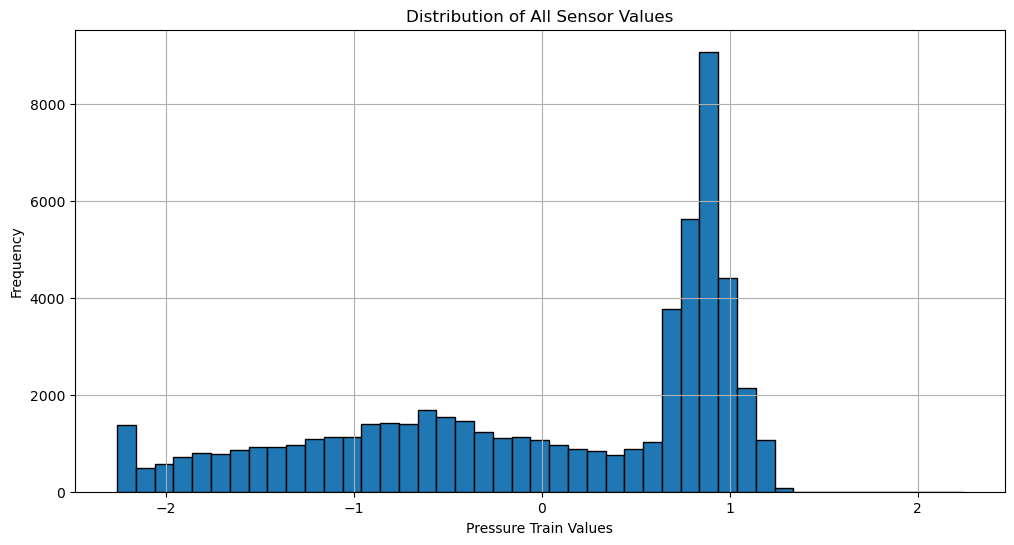

In [18]:
# Visualize distribution with a histogram again(code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

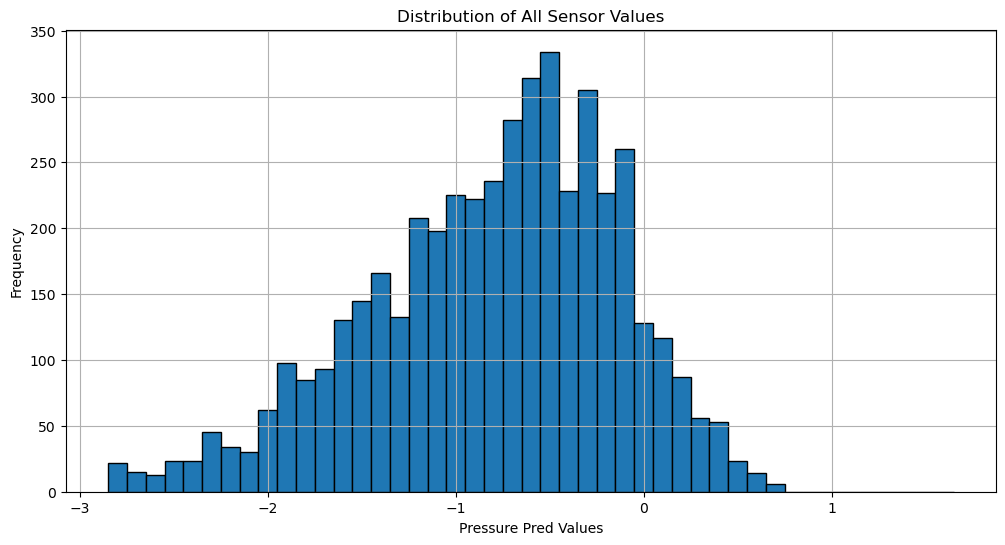

In [19]:
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<font color='red'> The distributions are very different and it might explain why the model performs very well on the validation set but not on the test set (Kaggle score): This is called distribution mismatch. Maybe cloning (in time) values 

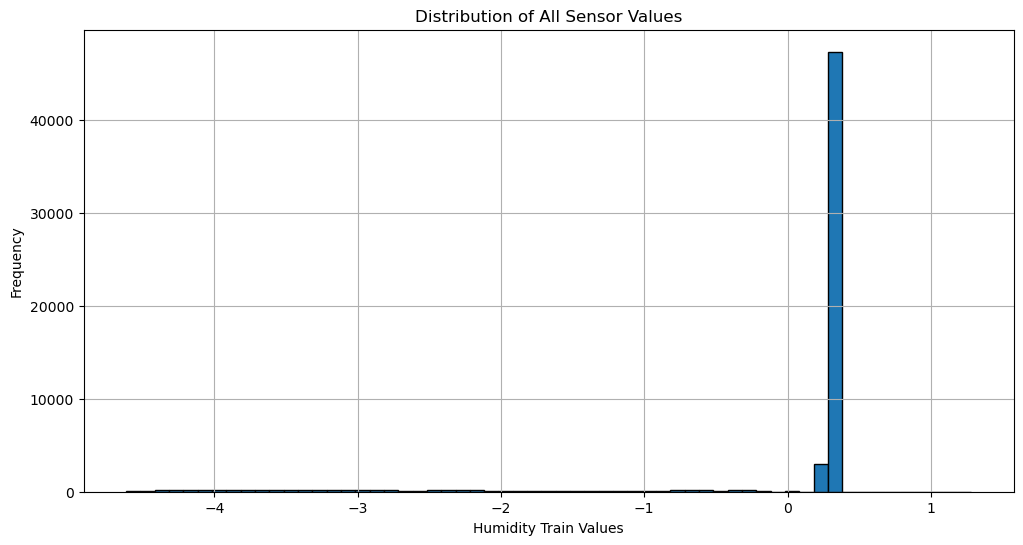

In [20]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

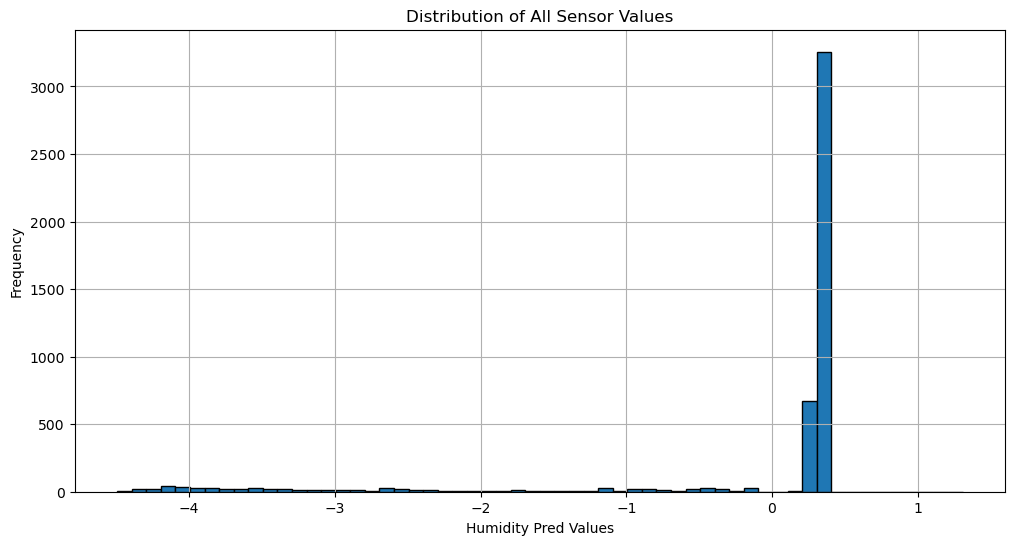

In [21]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

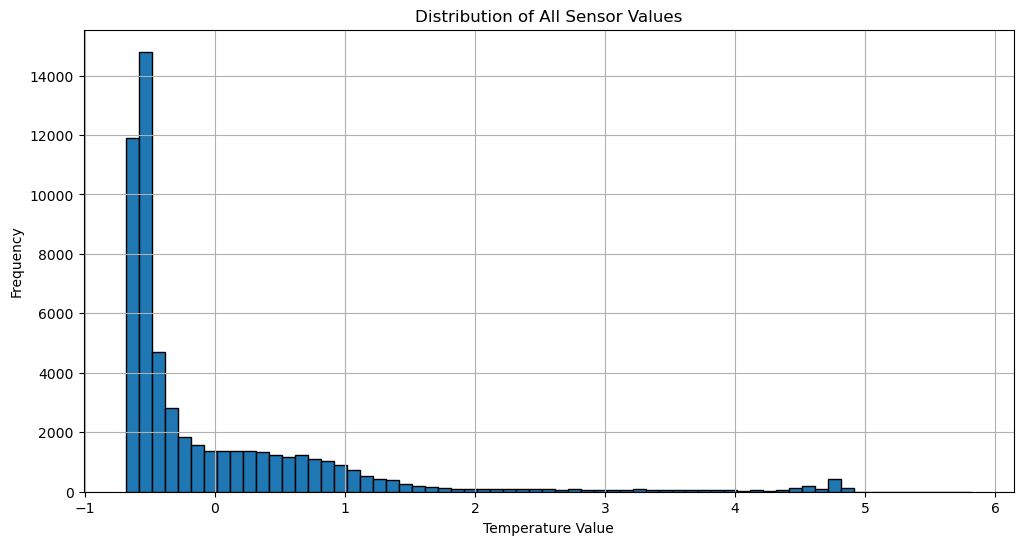

In [22]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Text(0.5, 0.92, '3D Temperature Distribution')

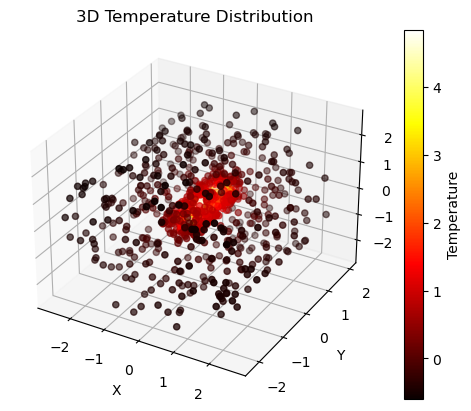

In [23]:
# # To plot the graph we have to remove faulty sensors from the position too so the dimensions match. 
# coordinates_train.drop(coordinates_train[coordinates_train["id"].isin(train_faulty_sensors)].index, inplace=True)

T = temperature_train.iloc[-1,1:].to_numpy()
x = coordinates_train["x"].to_numpy()
y = coordinates_train["y"].to_numpy()
z = coordinates_train["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')


All the chapes are matching, we can assume that indices match between each DataFrame

#### **Splitting data**  

We will first split the data into 3 sets with an arbitrary split: 
- Train set
- Validation set 
- Test set  

Later we'll implement a cross-validation for a better training.

In [ ]:
## The idea is to have a DataFrame for each time stamp as follows: 

#           | pressure | humidity | x | y | z | r |  materials... |
# ----------+----------+----------+---+---+---+---+---------------+
# N_1       |          |          |   |   |   |   |               |
# ...       |          |          |   |   |   |   |               |
# N_897     |          |          |   |   |   |   |               |

X_t: dict = {}
y_t: dict = {}

for i, t in enumerate(pressure_train['M.Time[d]']): 
    
    ## first, select the pressure data at the time
    X = pressure_train.iloc[i, 1:]

    ## then the humidity
    H = humidity_train.iloc[i,1:]

    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))

    ## then add the coordinates and material features to the array 
    coords = coordinates_train.iloc[:,1:].to_numpy()

    ## adding the time as a feature in the last row too
    X = np.concatenate([X,H,coords, np.ones((X.shape[0], 1))*(t-time_mean)/time_std], axis = 1)

    ## add it to the dictionnary
    X_t[t] = X

for i, t in enumerate(time): 
    ## for each time we have the solution of the 900 sensors in a vector
    y = temperature_train.iloc[i, 1:]
    y_t[t] = y.to_numpy()

## grouping all the data in one array: 
X = np.vstack([matrix for matrix in X_t.values()])
y = np.vstack([vector for vector in y_t.values()])

## defining the number of features (useful later for the NN):
n_samples, n_features = X.shape


(900,)


SystemExit: 

c:\Users\Stefan\anaconda3\envs\introml\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### **Creating the model**  

For this project we will first try to use a vanilla neural network

#### **The model**

In [ ]:
class VanillaNN(nn.Module):
    """2-Layers Vanilla Neural Network"""
    
    def __init__(self, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(n_features+1,n_features+5)
        self.fc2 = nn.Linear(n_features+5,n_features)
        self.fc3 = nn.Linear(n_features,n_features)
        self.fc4 = nn.Linear(n_features,1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.leaky_relu(self.fc1(x), negative_slope=0.1, inplace=True)
        out = F.leaky_relu(self.fc2(out), negative_slope=0.1, inplace=True)
        out = F.leaky_relu(self.fc3(out), negative_slope=0.1, inplace=True)
        out = self.dropout(out)
        out = self.fc4(out)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)


## weight decay is the regularization strengh
## the optimizer parameters are optimal after some testing: lr=1e-3, weight_decay=2e-3

## The neural net below was inspired by one we found online and we wanted to test: 
## https://github.com/GuillaumeJadot/ML_project 
## We saw that a biiger net had better results on the training and validation sets.

class ThreeLayerNet(nn.Module):
    """
    Neural network model class. 
    """
    def __init__(self, input_size = 14, hidden_size = 25, middle_size=20, output_size=1, dropout_rate=0.4):
        """
        Initialize the model by setting up the layers.
        """
        super(ThreeLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, middle_size)
        self.fc3 = nn.Linear(middle_size, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.bn1 = nn.LayerNorm(hidden_size)
        self.bn2 = nn.LayerNorm(middle_size)
        self.bn3 = nn.LayerNorm(32)
        self.dropout = nn.Dropout(dropout_rate)

        # Apply Kaiming (He) initialization
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')

    def forward(self, x):
        """
        Perform a forward pass of our model on input features, x.
        """
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        out = self.fc4(x)
        return out
    


### **Validation**

In [ ]:
def validate(
        model: torch.nn.Module, 
        loss_fn: torch.nn.Module, 
        X_val: np.ndarray, 
        y_val: np.ndarray
) -> float:
    """Validate the model and return the average loss."""

    # Initialize metrics for loss:
    loss_metric = metrics.LossMetric()

    # Set the model to evaluation mode
    model.eval()  

    with torch.no_grad():  # Disable gradient calculation for validation

        X = X_val
        y = y_val

        assert X.shape[0] == y.shape[0], f"Size mismatch between X and y: {X.shape[0]}, {y.shape[0]}"

        for i in range(X.shape[0]):
            data = torch.from_numpy(np.array(X[i,:], dtype=np.float32)).unsqueeze(0).to(device) 
            target = torch.from_numpy(np.array(y[i], dtype=np.float32)).view(1, 1).to(device)

            # Forward pass
            out = model(data)
            loss = loss_fn(out, target)
            
            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
                
        final_loss = loss_metric.compute()
        loss_metric.reset()
        return final_loss

### **Training**
  
Each timestamp represents an epoch: data of the ~900 sensors.

In [ ]:
def train(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        X_train: np.ndarray, 
        y_train: np.ndarray,
        X_val: np.ndarray,
        y_val: np.ndarray,
        epochs = 5,
        batch_size=10
):

    # Initialize metrics for loss:
    loss_metric = metrics.LossMetric()

    ## set the module into training mode: 
    model.train()

    for epoch in range(1, epochs+1):

        ## Set up the progress bar: 
        pbar = tqdm(total=len(time_train)*900/batch_size, leave=True)
        pbar.set_description(f"epoch: {epoch}")

        X_i = X_train
        y_i = y_train

        ## Set the batch indices: 
        batch_indices = func.get_batch_indices(X.shape[0], batch_size)

        ## Iterate through the data:
        for i,j in batch_indices:
            
            data = torch.from_numpy( np.array( X_i[i:j,:], dtype=np.float32 ) ).reshape(batch_size, n_features+1).to(device)  
            # shape becomes (1, n_features): it is needed for nn.Linear
            target = torch.from_numpy( np.array( y_i[i:j], dtype=np.float32 ) ).reshape(batch_size, 1).to(device)

            # Zero-out the gradients
            optimizer.zero_grad()

            # Forward pass
            out = model(data)

            # Compute loss
            loss = loss_fn(out, target)

            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()

            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
            pbar.update()

        val_loss = validate(
            model=model,
            loss_fn=loss_fn,
            X_val=X_val,
            y_val=y_val
        )
                
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Validation loss: {val_loss:.3f}")
        loss_metric.reset()
                

In [ ]:
fold_results = []

for fold_idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):

    if fold_idx <= 0:
        print(f"\n=== Fold {fold_idx + 1} ===")

        # Build fold-specific datasets
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_val = X[val_idx]
        y_val = y[val_idx]

        ## reinitialize the model
        model = ThreeLayerNet().to(device)

        ## Loss & Optimizer:
        loss_fn = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=2e-3)


        # Train and validate
        train(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            epochs=7
        )

        val_loss = validate(model, loss_fn, X_val, y_val)
        
        fold_results.append(val_loss)

print(f"\nAverage Validation Loss: {np.mean(fold_results):.3f} ± {np.std(fold_results):.3f}")

## best train loss: 0.038
## best cross val loss: 0.076

ValueError: Found input variables with inconsistent numbers of samples: [56700, 63]

In [ ]:
## Pressure clipping search: (dropout = 0.0) 
## 0 : 0.443 : 0.549
## 500 : 0.260 : 0.722
## 1200 : 0.459 : 0.344
## 1400 : too high

## Neural net size: (tiny batch)
## 4 layers: [13,18,18,1], LeakyReLU(0.01): 0.30 train
## 4 layers: [13,18,8,1], LeakyReLU(0.01): ___ train
## 4 layers: [13,18,8,1], LeakyReLU(0.1): 0.23 train 
## 4 layers: [13,18,8,1], LeakyReLU(0.2): 0.36 train 
## 4 layers: [13,18,8,1], LeakyReLU(0.5): 0.35 train 

## Can the neural net overfitt small samples ? 
## -> clipping P at 0, no dropout

### **Testing**

let's do only one prediction first to see how it goes

In [ ]:
# lets try a few predictions : 
for i in range(5):
    t = random.choice(time)
    X = X_t[t]
    X = np.concatenate([X,np.ones((X.shape[0],1))*(t-time_pred_mean)/time_pred_std], axis = 1)
    y = y_t[t]
    pred = np.array([])

    for i in range(len(y)): 
        data = torch.from_numpy( np.array( X[i,:], dtype=np.float32 ) ) 
        pred = np.append(pred, model(data).detach().numpy()[0])

    print(pred[:6])
    print(y[:6])
    print(f"Error: {np.sqrt(func.MSE(pred*temperature_std + temperature_mean ,y*temperature_std + temperature_mean)):.3f} [°C]")

[-0.17167315 -0.4082056  -0.5889169  -0.62031806 -0.57939851 -0.62289345]
[-0.29816068 -0.41640251 -0.56410371 -0.5740431  -0.64272381 -0.63198209]
Error: 5.096 [°C]
[-0.47393194 -0.40722135 -0.57946241 -0.6297549  -0.58308589 -0.61139166]
[-0.48611833 -0.57432757 -0.56694394 -0.57891354 -0.64805101 -0.63512063]
Error: 5.153 [°C]
[-0.01870422 -0.4037967  -0.58822405 -0.60555148 -0.57697129 -0.62604392]
[-0.23720953 -0.34523209 -0.56057904 -0.56876867 -0.6360725  -0.62808061]
Error: 4.725 [°C]
[ 0.12179479 -0.37704954 -0.58911455 -0.55270028 -0.54273236 -0.62013483]
[-0.0953773  -0.16825698 -0.54074285 -0.54439927 -0.60424321 -0.60613439]
Error: 4.210 [°C]
[ 0.15219808 -0.34196335 -0.58345199 -0.52207673 -0.52469772 -0.61184311]
[-0.05313186 -0.11456848 -0.52993226 -0.53276012 -0.58873942 -0.59431643]
Error: 4.127 [°C]


### **Making a submission**

In [ ]:
X_t_pred = {}
sensor_IDs = pressure_pred.columns[1:]
pred = pd.DataFrame(data = sensor_IDs, columns=["id"])
display(pred)

for i, t in enumerate(pressure_pred['M.Time[d]']): 
    ## first, selsect the pressure data at the time
    X = pressure_pred.iloc[i, 1:]
    H = humidity_pred.iloc[i,1:]
    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))

    ## then add the coordinates and material features to the array 
    coords = coordinates_pred.iloc[:,1:].to_numpy()
    X = np.concatenate([X,H,coords], axis = 1)
    ## add it to the dictionnary
    X_t_pred[t] = X

for t in pressure_pred["M.Time[d]"]:

    X = X_t_pred[t]
    y_i = []
    X = np.concatenate([X, np.ones((X.shape[0], 1))*(t-time_pred_mean)/time_pred_std],axis=1)

    for i in range(X.shape[0]): 
        data = torch.from_numpy(np.array( X[i,:], dtype=np.float32 ) ) 
        y_i.append(model(data).detach().numpy()[0]*temperature_std + temperature_mean)

    pred[str(int(t))] = y_i
    y_i.clear()    

# display(pred)
pred.to_csv("data\\submission.csv", index=False)

,id
0,N_901
1,N_902
2,N_903
3,N_904
4,N_905
...,...
140,N_1042
141,N_1043
142,N_1044
143,N_1045


145


Text(0.5, 0.92, '3D Temperature Distribution')

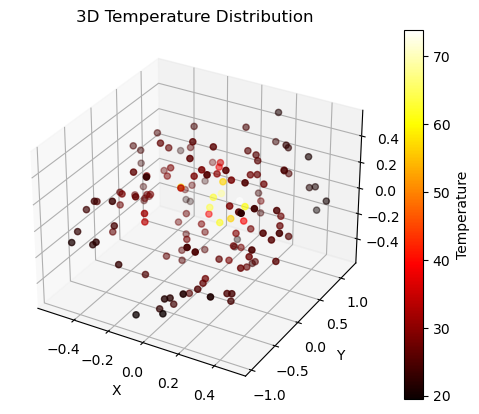

In [ ]:
print(len(pred))
T = pred.iloc[:, -20].to_numpy()
x = coordinates_pred["x"].to_numpy()
y = coordinates_pred["y"].to_numpy()
z = coordinates_pred["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')

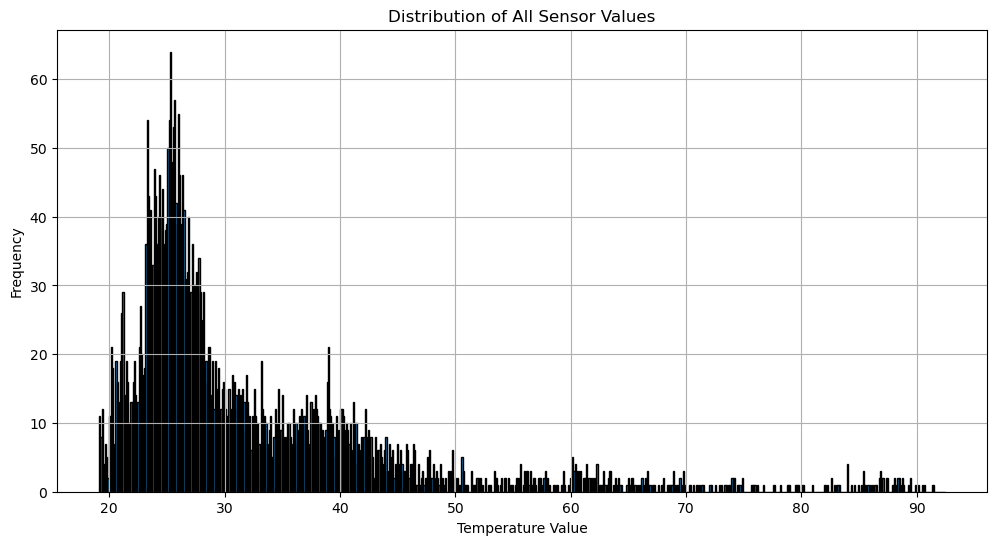

In [ ]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
